In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
df= pd.read_csv('loan_eligibility_data.csv')

In [3]:
# checking for missing values
missing_values = df.isna().sum()
missing_values_sorted = missing_values.sort_values(ascending=True)

print(missing_values_sorted)

Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
Married               3
Gender               13
Loan_Amount_Term     14
Dependents           15
LoanAmount           22
Self_Employed        32
Credit_History       50
dtype: int64


In [4]:
# Removing missing values using mode for specific columns

columns_to_impute = ['Credit_History', 'Self_Employed', 'Dependents', 'Gender', 'Married']

# Impute missing values using mode for the specified columns
for column in columns_to_impute:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)

# Impute missing values using median for specific columns
columns_to_impute = ['LoanAmount', 'Loan_Amount_Term']
for column in columns_to_impute:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

In [5]:
# checking for missing values
missing_values = df.isna().sum()
missing_values_sorted = missing_values.sort_values(ascending=True)

print(missing_values_sorted)

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [6]:
print(df.shape)

(614, 13)


In [7]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [8]:
# Dealing with outliers
def check_for_outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [9]:
# Data Encoding 
df['Loan_Status'] = df['Loan_Status'].replace('Y',1)
df['Loan_Status'] = df['Loan_Status'].replace('N',0)

df['Married'] = df['Married'].replace('Yes',1)
df['Married'] = df['Married'].replace('No',0)

df['Self_Employed'] = df['Self_Employed'].replace('Yes',1)
df['Self_Employed'] = df['Self_Employed'].replace('No',0)

df['Property_Area']= df['Property_Area'].replace('Urban',0)
df['Property_Area']= df['Property_Area'].replace('Rural',1)
df['Property_Area']= df['Property_Area'].replace('Semiurban',2)

df['Dependents']= df['Dependents'].replace('0',0)
df['Dependents']= df['Dependents'].replace('1',1)
df['Dependents']= df['Dependents'].replace('2',2)
df['Dependents']= df['Dependents'].replace('3+',3)

df['Gender'] = df['Gender'].replace('Male',1)
df['Gender'] = df['Gender'].replace('Female',0)

df['Education'] = df['Education'].replace('Graduate',1)
df['Education'] = df['Education'].replace('Not Graduate',0)

In [11]:
# normalise due to right skewed using Square Root Transformation

columns_to_normalise = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
df[columns_to_normalise] = df[columns_to_normalise].apply(np.sqrt)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    int64  
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    int64  
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    int64  
 12  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 62.5+ KB


In [13]:
# add co-applicant and applcant income together feature modification 
df['sum_columns'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Rename the 'sumed columns' column to a new name called Income
df = df.rename(columns={'sum_columns': 'Income'})

In [14]:
# Remove Duplicated and un useful data
df= df.drop('ApplicantIncome',axis=1)
df = df.drop('CoapplicantIncome',axis=1)
df = df.drop('Loan_ID',axis=1)

In [15]:
df.shape

(614, 11)

In [16]:
df1 = df

In [17]:
# Dropping the id column and reassigning the variables to represent the independent variables 
X = df1.drop(["Loan_Status"], axis=1)
y = df1["Loan_Status"]

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)
feature_importance = rf_classifier.feature_importances_
feature_importance_df1 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print the feature importance by rank
print("Feature Importance:")
print(feature_importance_df1)

Feature Importance:
            Feature  Importance
7    Credit_History    0.275749
9            Income    0.265592
5        LoanAmount    0.220402
2        Dependents    0.053687
8     Property_Area    0.049412
6  Loan_Amount_Term    0.042426
1           Married    0.025679
3         Education    0.022913
0            Gender    0.022392
4     Self_Employed    0.021749


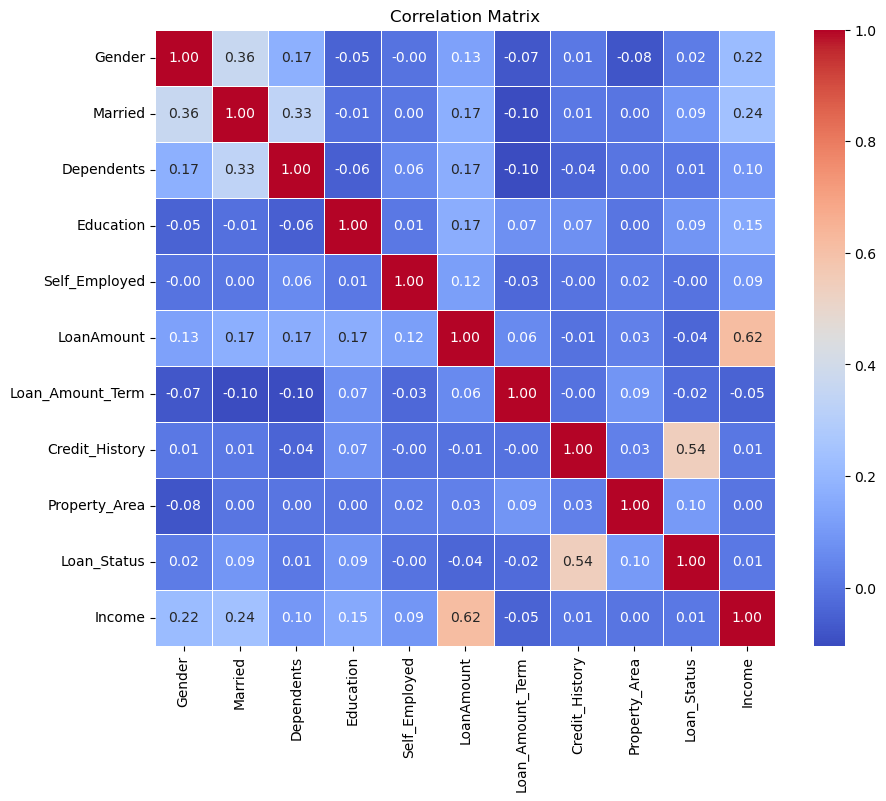

In [19]:
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

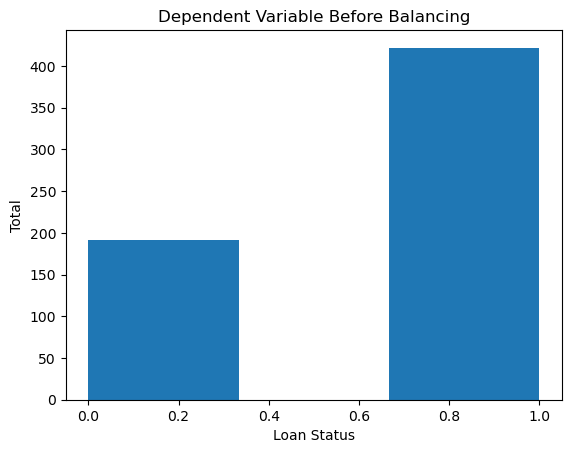

In [20]:
plt.hist(y, bins=3)
plt.title('Dependent Variable Before Balancing')
plt.xlabel('Loan Status')
plt.ylabel('Total')
plt.show()

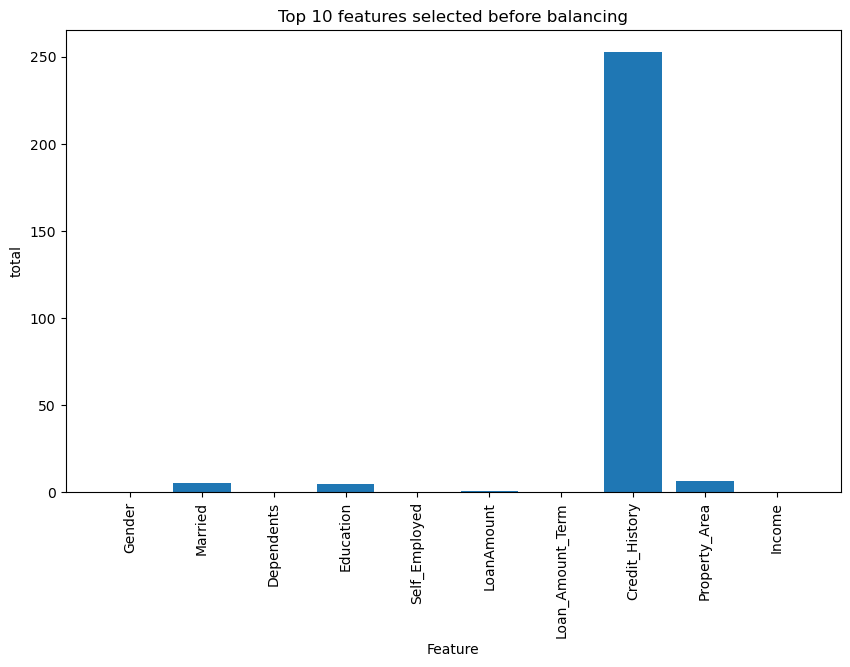

In [21]:
k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
X_topk = selector.transform(X)

# Plot selected features before balancing
plt.figure(figsize=(10,6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xticks(range(len(selector.scores_)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('total')
plt.title('Top {} features selected before balancing'.format(k))
plt.show()

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# 80% training and 20% test

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

dtree= DecisionTreeClassifier()
dtree=dtree.fit(X_train,y_train)
y_predict=dtree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_predict))

Train set: (491, 10) (491,)
Test set: (123, 10) (123,)
Accuracy: 0.6991869918699187


   control  Case
0       22    21
1       16    64


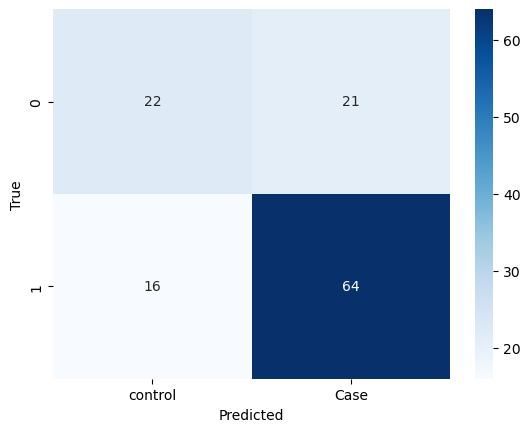

In [23]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54        43
           1       0.75      0.80      0.78        80

    accuracy                           0.70       123
   macro avg       0.67      0.66      0.66       123
weighted avg       0.69      0.70      0.69       123



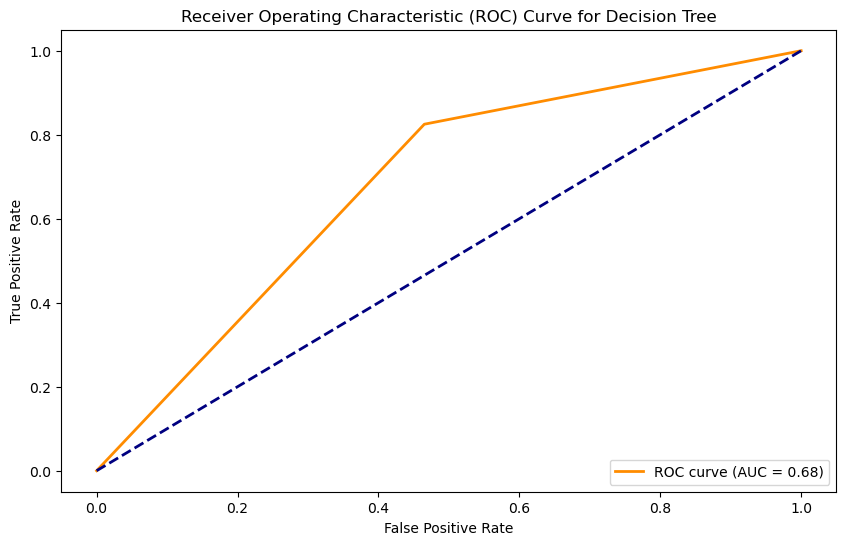

In [25]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_prob = dtree.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [26]:
# 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

dtree= DecisionTreeClassifier()
dtree=dtree.fit(X_train,y_train)
y_predict=dtree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_predict))

Train set: (460, 10) (460,)
Test set: (154, 10) (154,)
Accuracy: 0.7272727272727273


   control  Case
0       26    23
1       19    86


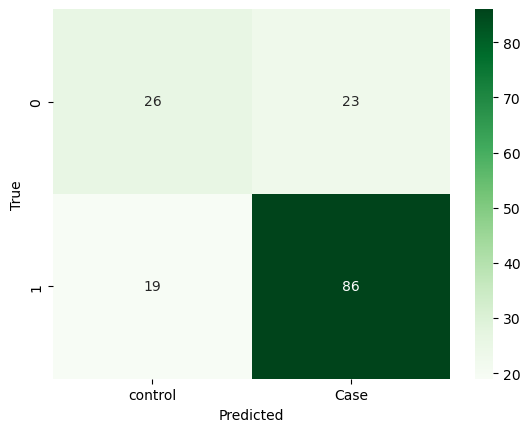

In [27]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.58      0.53      0.55        49
           1       0.79      0.82      0.80       105

    accuracy                           0.73       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.72      0.73      0.72       154



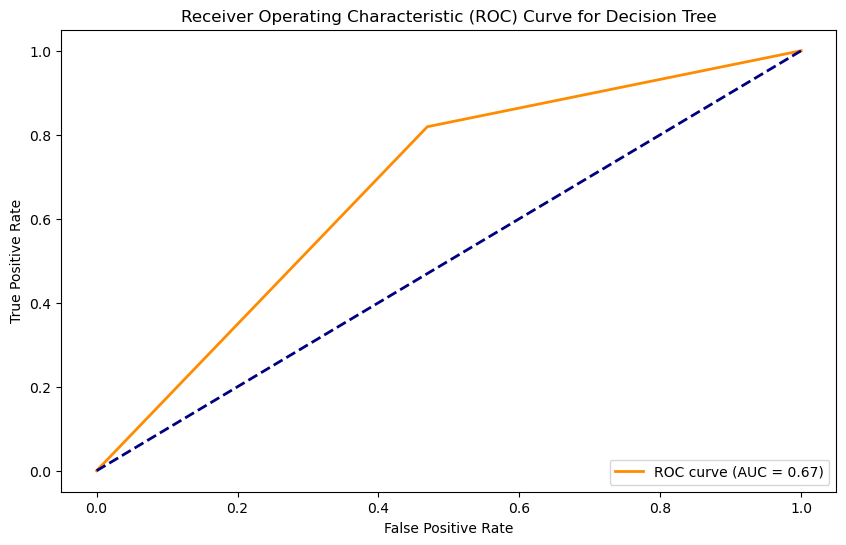

In [29]:
y_prob = dtree.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [32]:
# 70% training and 30% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

dtree= DecisionTreeClassifier()
dtree=dtree.fit(X_train,y_train)
y_predict=dtree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_predict))

Train set: (429, 10) (429,)
Test set: (185, 10) (185,)
Accuracy: 0.7081081081081081


   control  Case
0       31    30
1       24   100


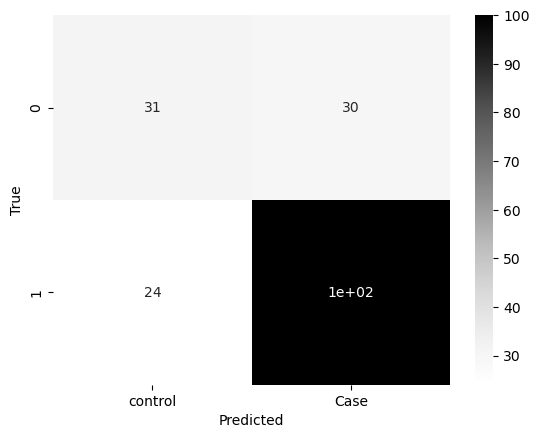

In [33]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

sns.heatmap(df_cm, annot=True, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.56      0.51      0.53        61
           1       0.77      0.81      0.79       124

    accuracy                           0.71       185
   macro avg       0.67      0.66      0.66       185
weighted avg       0.70      0.71      0.70       185



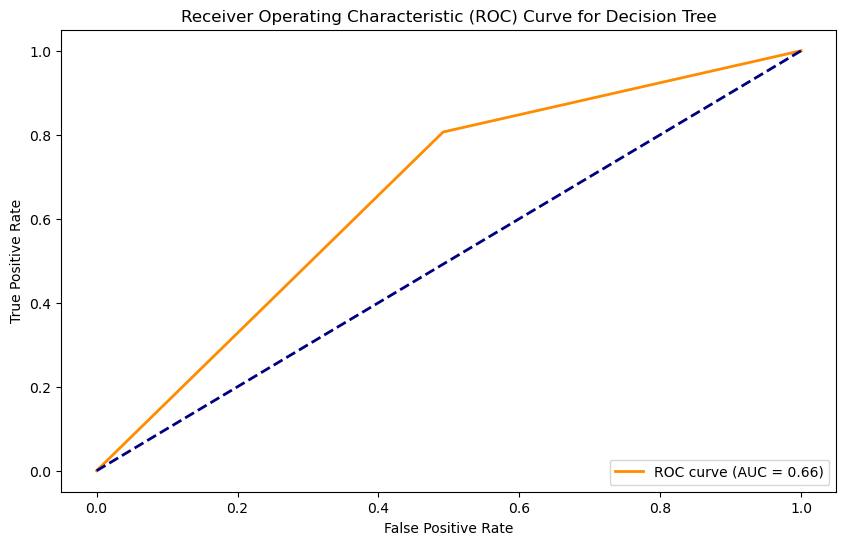

In [35]:
y_prob = dtree.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [37]:
df3= df1

In [38]:
# Dropping the id column and reassigning the variables to represent the independent variables 
X = df3.drop(["Loan_Status"], axis=1)
y = df3["Loan_Status"]

In [39]:
# Perform oversampling on the data
X, y = SMOTE().fit_resample(X, y)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

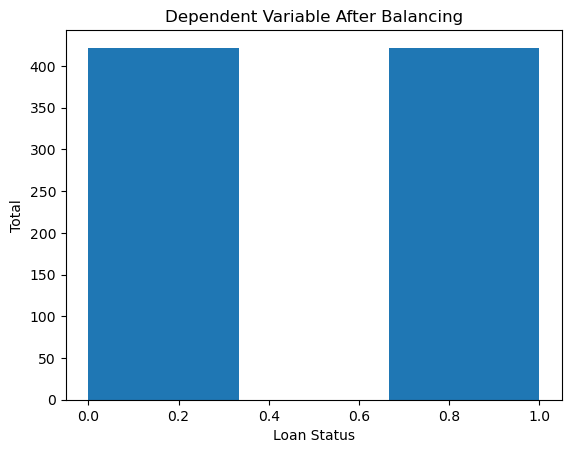

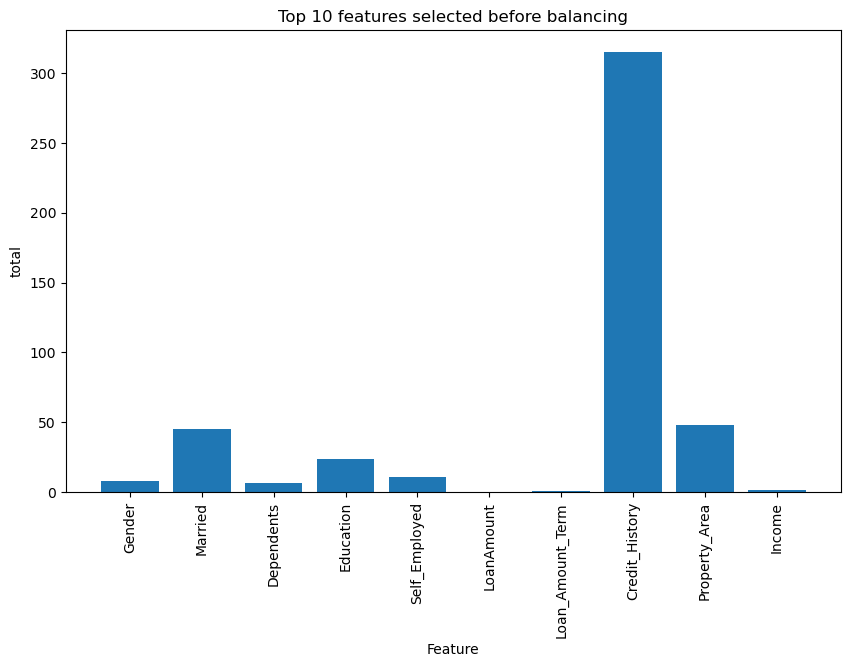

In [40]:
plt.hist(y, bins=3)
plt.title('Dependent Variable After Balancing')
plt.xlabel('Loan Status')
plt.ylabel('Total')
plt.show()

k = 10
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
X_topk = selector.transform(X)

# Plot selected features before balancing
plt.figure(figsize=(10,6))
plt.bar(range(len(selector.scores_)), selector.scores_)
plt.xticks(range(len(selector.scores_)), X.columns, rotation=90)
plt.xlabel('Feature')
plt.ylabel('total')
plt.title('Top {} features selected before balancing'.format(k))
plt.show()

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # 80% training and 20% test
dtree= DecisionTreeClassifier()
dtree=dtree.fit(X_train,y_train)
y_predict=dtree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.7810650887573964


   control  Case
0       73    21
1       16    59


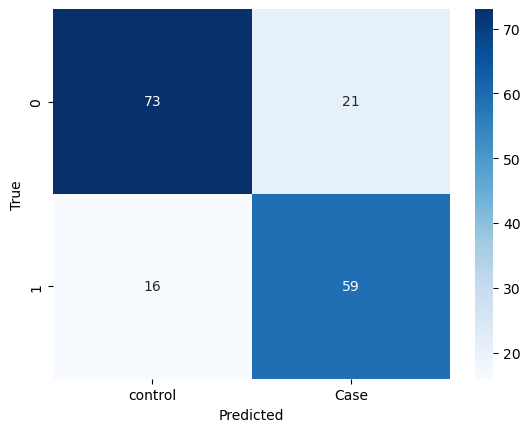

In [42]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)

sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
     

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        94
           1       0.74      0.79      0.76        75

    accuracy                           0.78       169
   macro avg       0.78      0.78      0.78       169
weighted avg       0.78      0.78      0.78       169



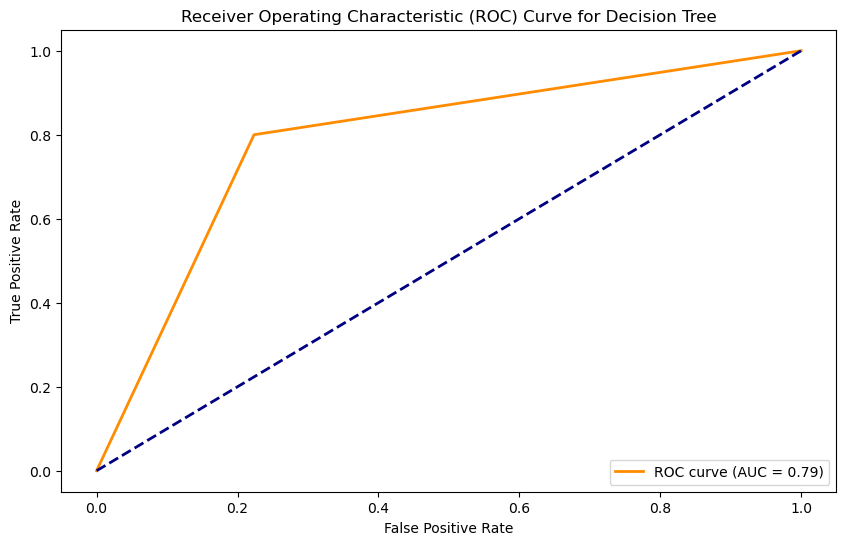

In [44]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_prob = dtree.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)# 75% training and 25% test
dtree= DecisionTreeClassifier()
dtree=dtree.fit(X_train,y_train)
y_predict=dtree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.7488151658767772


   control  Case
0       87    27
1       26    71


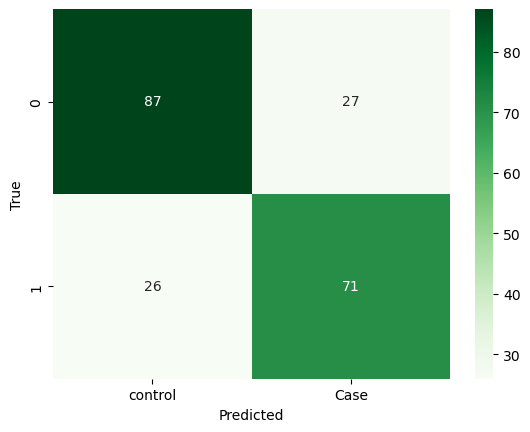

In [50]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)
sns.heatmap(df_cm, annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       114
           1       0.72      0.73      0.73        97

    accuracy                           0.75       211
   macro avg       0.75      0.75      0.75       211
weighted avg       0.75      0.75      0.75       211



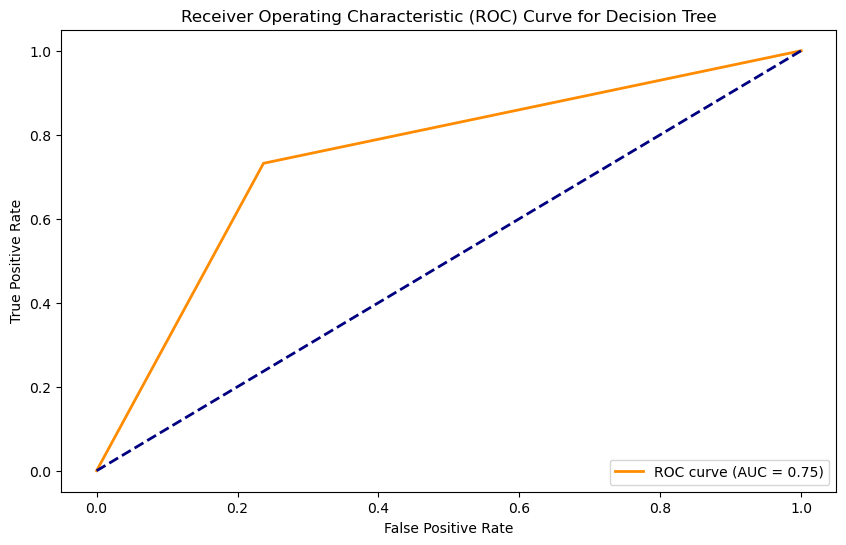

In [52]:
y_prob = dtree.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)# 70% training and 30% test
dtree= DecisionTreeClassifier()
dtree=dtree.fit(X_train,y_train)
y_predict=dtree.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.7598425196850394


   control  Case
0      105    31
1       30    88


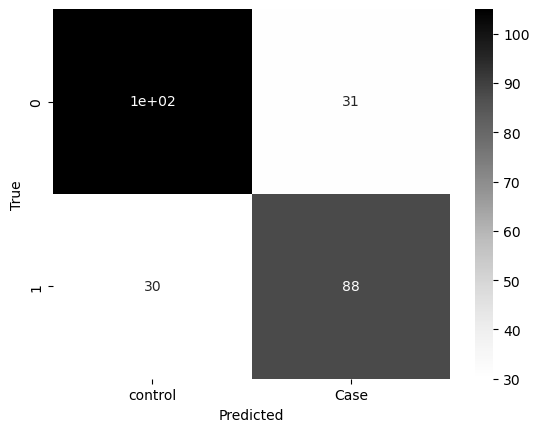

In [62]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=['0','1'], 
                     columns = ['control','Case'])
print(df_cm)
sns.heatmap(df_cm, annot=True, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       136
           1       0.74      0.75      0.74       118

    accuracy                           0.76       254
   macro avg       0.76      0.76      0.76       254
weighted avg       0.76      0.76      0.76       254



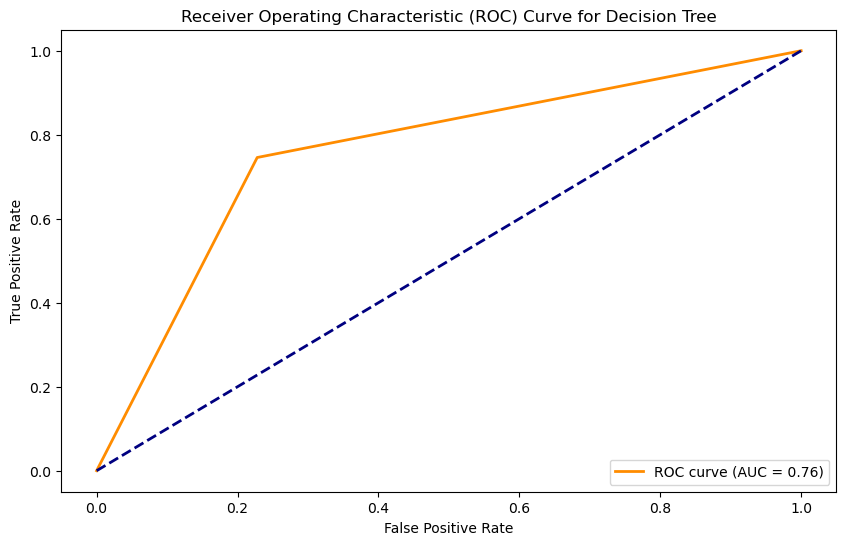

In [60]:
y_prob = dtree.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()